# Preparación de Datos para Predicción de Criptomonedas


Usamos el archivo CSV existente en lugar de volver a conectarse a la base de datos.

In [ ]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
import holidays

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore')

# Configurar opciones de visualización para pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [ ]:
# Instalar holidays si falta
%pip install holidays
import holidays

##  Carga de Datos (desde csv)

En lugar de volver a conectarnos a la base de datos, utilizaremos el archivo CSV que ya hemos generado en el notebook anterior.

In [2]:
# Cargar datos desde el CSV existente
all_data = pd.read_csv('../data/processed_crypto_data.csv')

# Convertir la columna de fecha a datetime
all_data['fetch_date'] = pd.to_datetime(all_data['fetch_date'])

# Verificar datos cargados
print("Número de registros por moneda:")
print(all_data.groupby('coin_id').size())
print("\nRango de fechas disponibles:")
print(f"Desde: {all_data['fetch_date'].min()}")
print(f"Hasta: {all_data['fetch_date'].max()}")

# Mostrar las primeras filas para entender la estructura
all_data.head()

Número de registros por moneda:
coin_id
bitcoin     242
cardano     252
ethereum    245
dtype: int64

Rango de fechas disponibles:
Desde: 2024-09-01 00:00:00
Hasta: 2025-05-17 00:00:00


,coin_id,price_usd,fetch_date,pct_change,year,month,year_month,risk_level,rolling_7d_trend,rolling_7d_variance
0,bitcoin,58960.236587,2024-09-01,NaN,2024,9,2024-09,Low Risk,NaN,NaN
1,bitcoin,57357.716173,2024-09-02,-2.717968,2024,9,2024-09,Low Risk,NaN,NaN
2,bitcoin,59108.732359,2024-09-03,3.052800,2024,9,2024-09,Low Risk,NaN,NaN
3,bitcoin,57504.538586,2024-09-04,-2.713971,2024,9,2024-09,Low Risk,NaN,NaN
4,bitcoin,57987.846014,2024-09-05,0.840468,2024,9,2024-09,Low Risk,NaN,NaN


## 4.3. Reestructuración de los Datos para Predicción

Siguiendo la consigna, vamos a:
1. Agregar los precios de los últimos 7 días como columnas
2. Agregar el precio del día siguiente como variable objetivo
3. Agregar características adicionales para mejorar la predicción

In [5]:
# Proceso por cada moneda
coins = all_data['coin_id'].unique()
prediction_dfs = {}

for coin in coins:
    print(f"\nProcesando datos para {coin}...")
    
    # Filtrar por moneda y ordenar por fecha
    coin_data = all_data[all_data['coin_id'] == coin].sort_values('fetch_date').copy()
    
    # Asegurarnos que los datos estén ordenados cronológicamente
    coin_data = coin_data.sort_values('fetch_date').reset_index(drop=True)
    
    # a. Agregar características de precios de los últimos 7 días
    for i in range(1, 8):
        coin_data[f'price_lag_{i}'] = coin_data['price_usd'].shift(i)
    
    # b. Agregar el precio del día siguiente (target)
    coin_data['next_day_price'] = coin_data['price_usd'].shift(-1)
    
    # c. Feature engineering adicional - Asimetría (skewness) de los precios en ventana de 7 días
    coin_data['price_skew_7d'] = coin_data['price_usd'].rolling(window=7).skew()
    
    # d. Características basadas en el tiempo
    # Día de la semana (0=lunes, 6=domingo)
    coin_data['day_of_week'] = coin_data['fetch_date'].dt.dayofweek
    
    # Nombre del día de la semana
    day_names = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
    coin_data['day_name'] = coin_data['day_of_week'].map(day_names)
    
    # Fin de semana (1=sí, 0=no)
    coin_data['is_weekend'] = coin_data['day_of_week'].isin([5, 6]).astype(int)
    
    # Semana del año
    coin_data['week_of_year'] = coin_data['fetch_date'].dt.isocalendar().week
    
    # Día del mes
    coin_data['day_of_month'] = coin_data['fetch_date'].dt.day
    
    # Cuarto de año (trimestre)
    coin_data['quarter'] = coin_data['fetch_date'].dt.quarter
    
    # Día del año
    coin_data['day_of_year'] = coin_data['fetch_date'].dt.dayofyear
    
    # e. Características de los días festivos (aunque no tenemos datos de volumen en el CSV existente)
    # Podemos agregar características ficticias usando el retorno diario como proxy de volumen
    coin_data['return_abs'] = coin_data['pct_change'].abs()
    coin_data['return_rolling_mean_7d'] = coin_data['return_abs'].rolling(window=7).mean()
    
    # f. Características de los días festivos
    # Feriado en US
    us_holidays = holidays.US()
    coin_data['is_us_holiday'] = coin_data['fetch_date'].apply(lambda x: x in us_holidays).astype(int)
    
    # Feriado en China
    cn_holidays = holidays.China()
    coin_data['is_china_holiday'] = coin_data['fetch_date'].apply(lambda x: x in cn_holidays).astype(int)
    
    # Día previo a feriado en US
    coin_data['is_pre_us_holiday'] = coin_data['fetch_date'].apply(
        lambda x: (x + timedelta(days=1)) in us_holidays).astype(int)
    
    # g. Escalado de características
    # Crear una versión normalizada del precio (0-1)
    scaler = MinMaxScaler()
    coin_data['price_normalized'] = scaler.fit_transform(coin_data[['price_usd']])
    
    # Standardización del precio (media=0, std=1)
    coin_data['price_standardized'] = stats.zscore(coin_data['price_usd'], nan_policy='omit')
    
    # Eliminar filas con valores NaN (causados por los lags)
    coin_data = coin_data.dropna()
    
    # Guardar dataframe procesado
    prediction_dfs[coin] = coin_data

# Mostrar un ejemplo del dataframe resultante
print("\nEjemplo de dataframe procesado para Bitcoin:")
display(prediction_dfs['bitcoin'].head())


Procesando datos para bitcoin...

Procesando datos para cardano...

Procesando datos para ethereum...

Ejemplo de dataframe procesado para Bitcoin:


,coin_id,price_usd,fetch_date,pct_change,year,month,year_month,risk_level,rolling_7d_trend,rolling_7d_variance,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6,price_lag_7,next_day_price,price_skew_7d,day_of_week,day_name,is_weekend,week_of_year,day_of_month,quarter,day_of_year,return_abs,return_rolling_mean_7d,is_us_holiday,is_china_holiday,is_pre_us_holiday,price_normalized,price_standardized
7,bitcoin,54150.938359,2024-09-08,0.422048,2024,9,2024-09,Low Risk,-8.156850,3.485964e+06,53923.356111,56132.404732,57987.846014,57504.538586,59108.732359,57357.716173,58960.236587,54792.407558,-0.435166,6,Domingo,1,36,8,3,252,0.422048,2.411770,0,0,0,0.004355,-2.109056
8,bitcoin,54792.407558,2024-09-09,1.184595,2024,9,2024-09,Low Risk,-4.472473,3.229549e+06,54150.938359,53923.356111,56132.404732,57987.846014,57504.538586,59108.732359,57357.716173,57049.118751,0.201738,0,Lunes,0,37,9,3,253,1.184595,2.192716,0,0,0,0.016630,-2.066126
9,bitcoin,57049.118751,2024-09-10,4.118657,2024,9,2024-09,Low Risk,-3.484449,3.163743e+06,54792.407558,54150.938359,53923.356111,56132.404732,57987.846014,57504.538586,59108.732359,57624.161783,-0.070218,1,Martes,0,37,10,3,254,4.118657,2.344981,0,0,0,0.059813,-1.915096
10,bitcoin,57624.161783,2024-09-11,1.007979,2024,9,2024-09,Low Risk,0.208024,2.373928e+06,57049.118751,54792.407558,54150.938359,53923.356111,56132.404732,57987.846014,57504.538586,57381.764445,-0.063440,2,Miércoles,0,37,11,3,255,1.007979,2.101268,0,0,0,0.070817,-1.876612
11,bitcoin,57381.764445,2024-09-12,-0.420652,2024,9,2024-09,Low Risk,-1.045187,2.333866e+06,57624.161783,57049.118751,54792.407558,54150.938359,53923.356111,56132.404732,57987.846014,58106.951230,-0.180309,3,Jueves,0,37,12,3,256,0.420652,2.041295,0,0,0,0.066178,-1.892834


In [6]:
# Guardar los datos procesados para cada moneda
for coin, df in prediction_dfs.items():
    output_path = f"../data/{coin}_prediction_data.csv"
    df.to_csv(output_path, index=False)
    print(f"Datos de {coin} guardados en {output_path}")

Datos de bitcoin guardados en ../data/bitcoin_prediction_data.csv
Datos de cardano guardados en ../data/cardano_prediction_data.csv
Datos de ethereum guardados en ../data/ethereum_prediction_data.csv


## Matriz de correlacion

Veamos cómo se relacionan las distintas características con el precio del día siguiente.

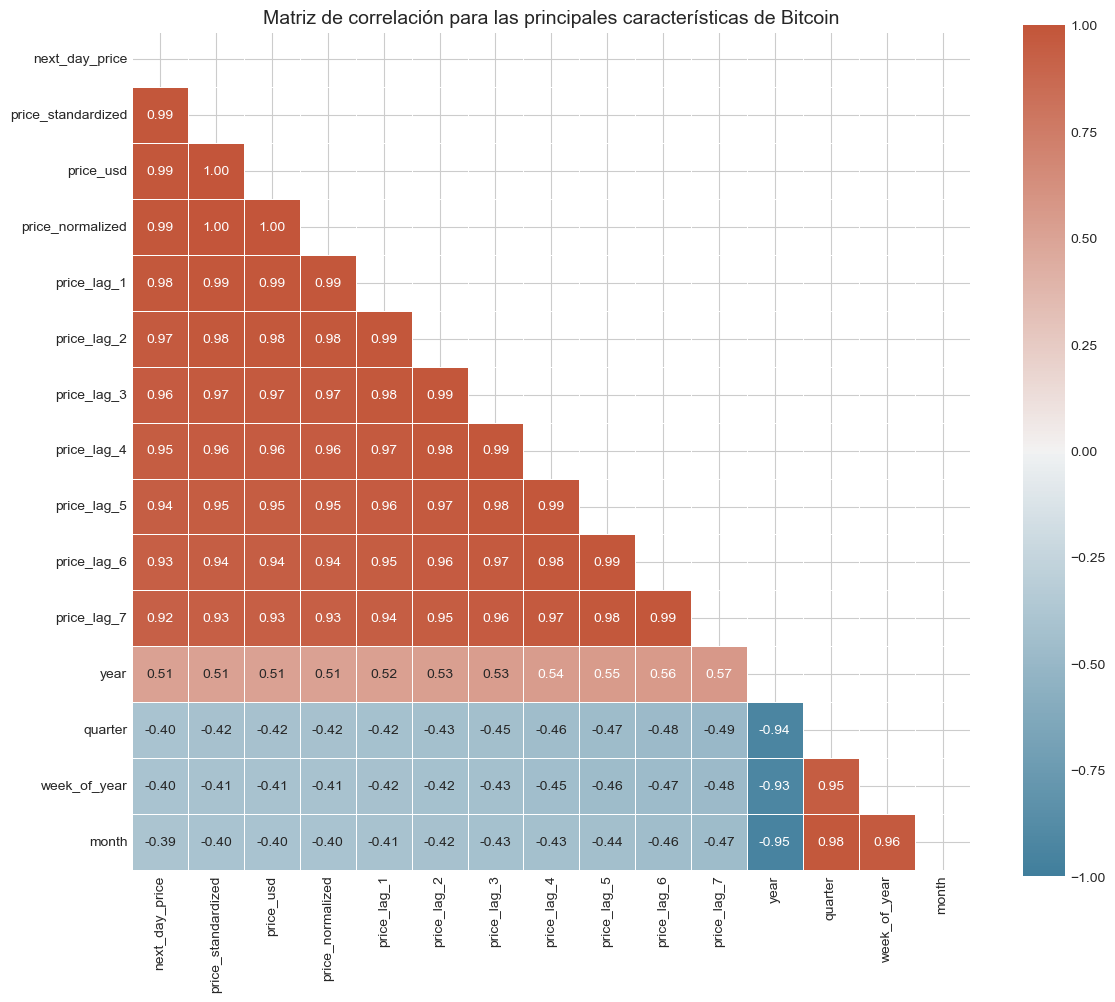

In [7]:
# Análisis de correlación para Bitcoin
btc_data = prediction_dfs['bitcoin']

# Seleccionar solo columnas numéricas para el cálculo de correlaciones
numeric_cols = btc_data.select_dtypes(include=['number']).columns
btc_data_numeric = btc_data[numeric_cols]

# Verificar si 'next_day_price' está en las columnas numéricas
if 'next_day_price' not in numeric_cols:
    print("Error: 'next_day_price' no es una columna numérica en el dataframe.")
else:
    # Calcular la matriz de correlación completa
    corr_matrix = btc_data_numeric.corr()
    
    # Para una matriz más legible, podemos seleccionar las características más relevantes
    # Por ejemplo, las que más se correlacionan con next_day_price
    relevant_features = corr_matrix['next_day_price'].abs().sort_values(ascending=False).head(15).index
    
    # Crear una submatriz con las características más relevantes
    relevant_corr_matrix = corr_matrix.loc[relevant_features, relevant_features]
    
    # Visualizar la matriz de correlación
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(relevant_corr_matrix, dtype=bool))  # Máscara para mostrar solo la mitad inferior
    cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Paleta de colores
    
    sns.heatmap(
        relevant_corr_matrix, 
        mask=mask,
        cmap=cmap, 
        vmax=1, 
        vmin=-1, 
        center=0,
        square=True, 
        linewidths=.5, 
        annot=True,  # Mostrar los valores
        fmt='.2f'  # Formato de dos decimales
    )
    
    plt.title('Matriz de correlación para las principales características de Bitcoin', fontsize=14)
    plt.tight_layout()
    plt.savefig('../data/btc_correlation_matrix.png')
    plt.show()

Se observa una fuerte correlación positiva entre el precio del día siguiente y los precios de los últimos días, lo que confirma que el precio tiene una alta inercia temporal. Las variables de tiempo (mes, semana, trimestre) presentan correlaciones más débiles o incluso negativas, lo que sugiere que su aporte al modelo podría ser limitado o más complejo de interpretar.